# **다중분류 실습: MNIST 손글씨 분류**

<center><img src = "https://github.com/Jangrae/img/blob/master/mnist.png?raw=true" width=800/></center>

- MNIST는 28×28 픽셀 흑백 손글씨 숫자(0~9) 이미지 데이터 셋입니다.
- 구성은 학습용 60,000장, 검증용 10,000장으로 되어 있습니다.
- 머신러닝, 딥러닝 모델 학습과 기본 성능 평가에 사용됩니다.

## **1. 환경준비**

### (1) 라이브러리 불러오기

- 학습량이 많기 때문에 GPU를 사용하는 것이 좋습니다.

In [1]:
# GPU 사용 가능 확인
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('* GPU 사용 가능:', gpus[0])
else:
    print('* GPU 사용 불가')

* GPU 사용 가능: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

### (2) 함수 만들기

In [3]:
# 함수 만들기
def dl_history_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', marker='.')
    plt.plot(history['val_loss'], label='Validation Loss', marker='.')

    plt.title('Learning Curve', size=15, pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### (3) 데이터 준비

In [4]:
# MNIST 불러오기
(x_train, y_train), (x_val, y_val) = mnist.load_data()

In [5]:
# 크기 확인
print(x_train.shape)
print(y_train.shape)
print('-' * 15)
print(x_val.shape)
print(y_val.shape)

(60000, 28, 28)
(60000,)
---------------
(10000, 28, 28)
(10000,)


## **2. 데이터 살펴보기**

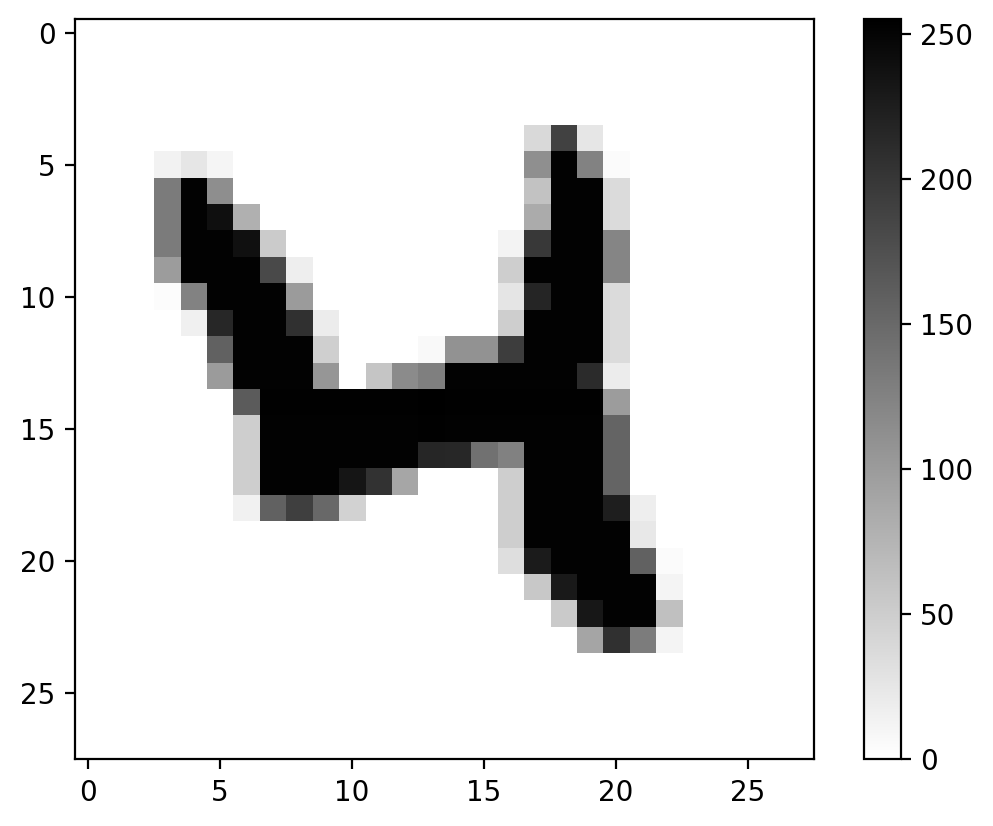

In [6]:
# 아래 숫자를 바꿔가며 확인
n = 20
plt.figure()
plt.imshow(x_train[n], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

In [7]:
# 값 확인
n = 20
for i in x_train[n]:
    for j in i:
        print(f'{j:3d}', end='')
    print('')

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38190 25  0  0  0  0  0  0  0  0
  0  0  0 13 25 10  0  0  0  0  0  0  0  0  0  0  0112252125  4  0  0  0  0  0  0  0
  0  0  0132252113  0  0  0  0  0  0  0  0  0  0  0 61252252 36  0  0  0  0  0  0  0
  0  0  0132252240 79  0  0  0  0  0  0  0  0  0  0 84252252 36  0  0  0  0  0  0  0
  0  0  0132252252238 52  0  0  0  0  0  0  0  0 12198252252122  0  0  0  0  0  0  0
  0  0  0 99252252252181 17  0  0  0  0  0  0  0 49252252252122  0  0  0  0  0  0  0
  0  0  0  3125252252252100  0  0  0  0  0  0  0 26218252252 36  0  0  0  0  0  0  0
  0  0  0  0 15216252252207 19  0  0  0  0  0  0 49252252252 36  

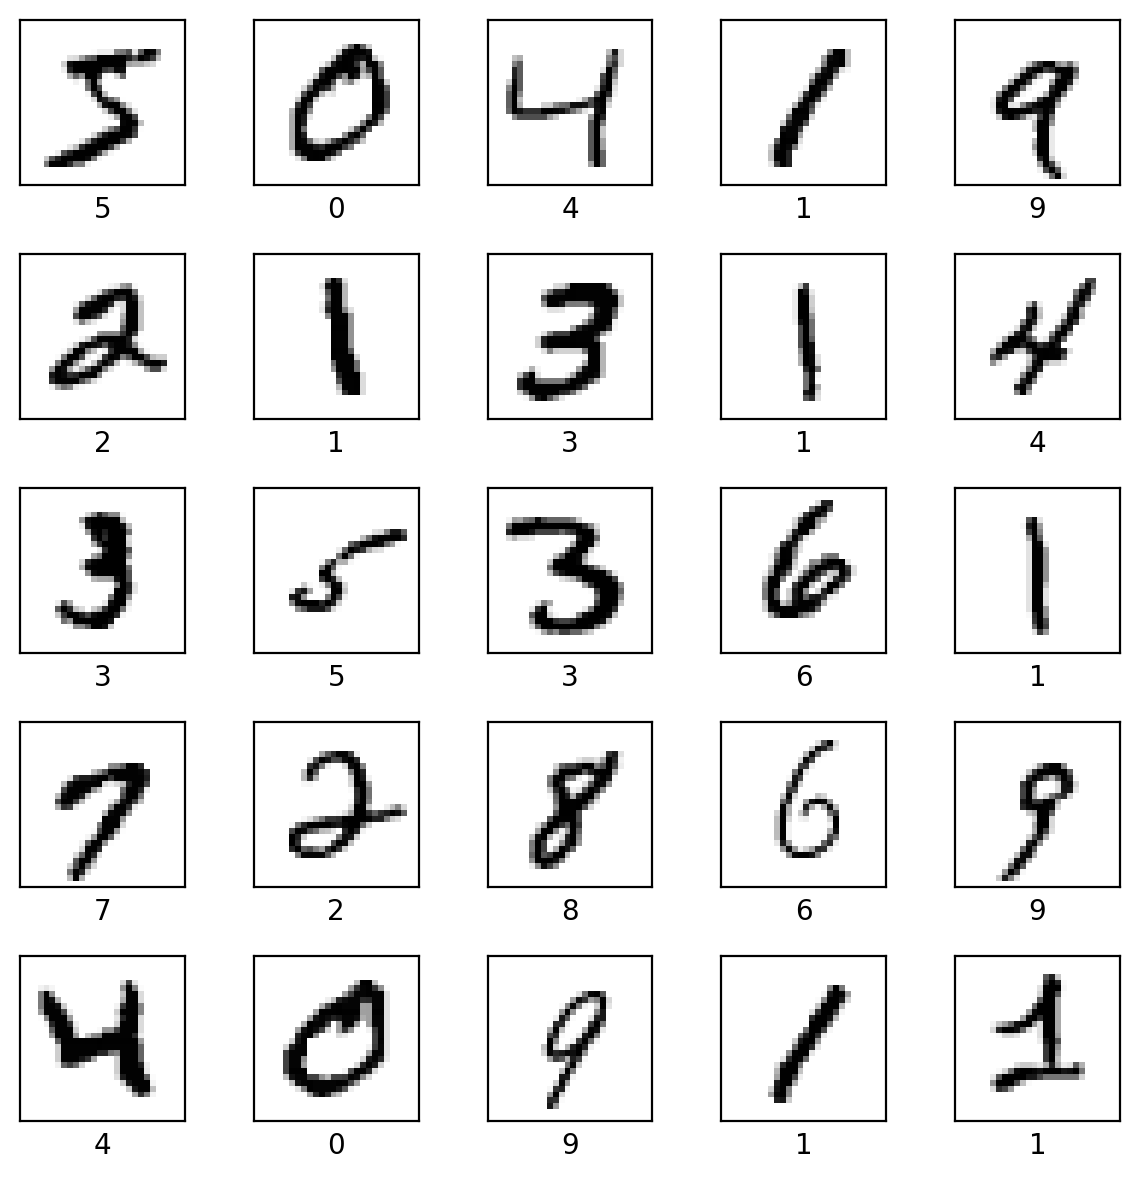

In [8]:
# 25개 확인
class_names = list('0123456789')
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.tight_layout()
plt.show()

## **3. 데이터 전처리**

### (1) 2차원으로 펼치기

In [9]:
# 변환 전
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [10]:
# 2차원 변환
x_train = x_train.reshape(60000, -1)
x_val = x_val.reshape(10000, -1)

In [11]:
# 변환 후
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### (2) 스케일링

- 0 - 255 값으로 되어 있는 데이터를 0 - 1사이 값으로 변환합니다.
- x_train, x_val을 그냥 255로 나누면 됩니다.

In [12]:
# 0 ~ 1 사이 값으로 변환
x_train = x_train / 255
x_val = x_val / 255

## **4. 모델링 1**

### (1) 모델 선언

In [13]:
nf = x_train.shape[1]

model = Sequential([
    Input(shape=(nf,)),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### (2) 모델 학습

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val)).history

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8213 - loss: 0.7016 - val_accuracy: 0.9157 - val_loss: 0.3082
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9131 - loss: 0.3103 - val_accuracy: 0.9208 - val_loss: 0.2847
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9217 - loss: 0.2815 - val_accuracy: 0.9247 - val_loss: 0.2722
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9220 - loss: 0.2759 - val_accuracy: 0.9248 - val_loss: 0.2685
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9247 - loss: 0.2686 - val_accuracy: 0.9249 - val_loss: 0.2695
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9279 - loss: 0.2628 - val_accuracy: 0.9264 - val_loss: 0.2644
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9295 - loss: 0.2525 - val_accuracy: 0.9259 - val_loss: 0.2665
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9297 - loss: 0.2537 - 

### (3) 예측 및 성능 평가

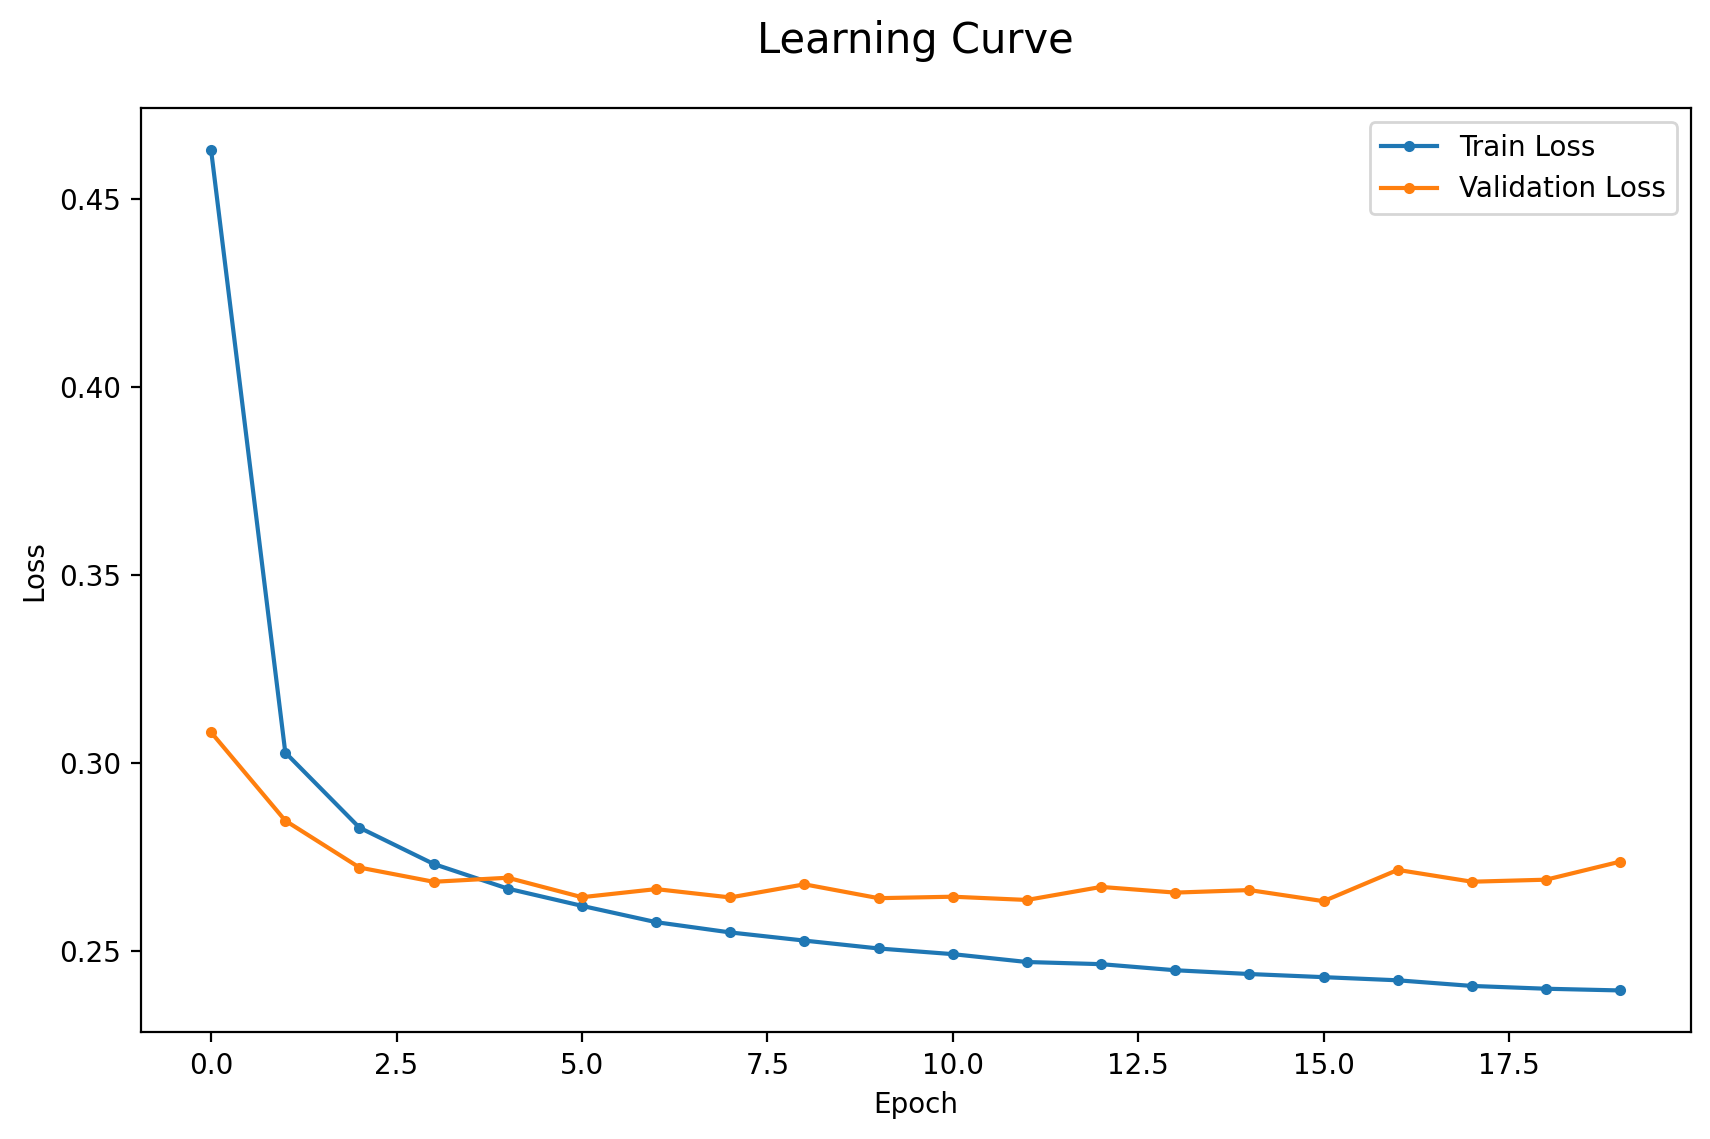

In [16]:
dl_history_plot(hist)

In [17]:
y_pred = model.predict(x_val)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[6.9731783e-08, 4.1467901e-14, 1.2439062e-07, ..., 9.9317729e-01,
        6.6018270e-06, 3.4441179e-04],
       [3.9545099e-05, 1.2544044e-06, 9.9402630e-01, ..., 2.7052416e-22,
        4.9853834e-06, 3.4683213e-19],
       [3.0669355e-07, 9.8666078e-01, 9.0302294e-03, ..., 2.0040026e-05,
        1.4222548e-03, 1.2385935e-04],
       ...,
       [3.8501051e-09, 3.5084213e-10, 1.1895859e-06, ..., 7.2318612e-04,
        4.0903976e-03, 1.9218143e-02],
       [4.1052237e-09, 5.3519553e-09, 4.3030917e-09, ..., 1.1539944e-08,
        2.2718690e-03, 3.4527017e-09],
       [4.6932652e-08, 2.6230138e-16, 2.0546608e-05, ..., 1.0917749e-18,
        5.2059457e-10, 1.2628467e-13]], dtype=float32)

In [18]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [19]:
# 정확도
acc = accuracy_score(y_val, y_pred)
print("정확도(Accuracy):", acc)

# 분류 리포트 (precision, recall, f1-score)
print(classification_report(y_val, y_pred, zero_division=0))

# 혼동행렬
print(confusion_matrix(y_val, y_pred))


정확도(Accuracy): 0.9246
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.89      0.92      1032
           3       0.88      0.93      0.90      1010
           4       0.94      0.93      0.93       982
           5       0.89      0.88      0.88       892
           6       0.95      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.91      0.85      0.88       974
           9       0.89      0.93      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[ 963    0    0    2    1    7    3    3    1    0]
 [   0 1117    3    3    0    2    3    2    5    0]
 [   9    9  917   23    7    4   12   10   36    5]
 [   2    0   11  937    1   25    1    9   12   12]
 [   1 

## **5. 모델링 2**

- Hidden Layer를 추가하여 다양한 모델을 만들고 성능을 비교해 봅니다.
- 성능에 영향을 주는 요인은
    - Hidden Layer 수
    - Node 수
    - epochs 수 (10 ~ 20 사이에서 결정)
    - learning_rate

#### 1) 모델 선언

In [20]:
model2 = Sequential([
    Input(shape=(nf,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model2.compile(optimizer=Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

#### 2) 모델 학습

In [22]:
hist2 = model2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val)).history

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8506 - loss: 0.5182 - val_accuracy: 0.9549 - val_loss: 0.1558
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9567 - loss: 0.1449 - val_accuracy: 0.9674 - val_loss: 0.1080
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9676 - loss: 0.1056 - val_accuracy: 0.9642 - val_loss: 0.1177
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9747 - loss: 0.0827 - val_accuracy: 0.9697 - val_loss: 0.0991
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9799 - loss: 0.0662 - val_accuracy: 0.9703 - val_loss: 0.1022
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9832 - loss: 0.0546 - val_accuracy: 0.9729 - val_loss: 0.0881
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9847 - loss: 0.0477 - val_accuracy: 0.9730 - val_loss: 0.0885
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9866 - loss: 0.0392 - 

#### 3) 예측 및 성능 평가

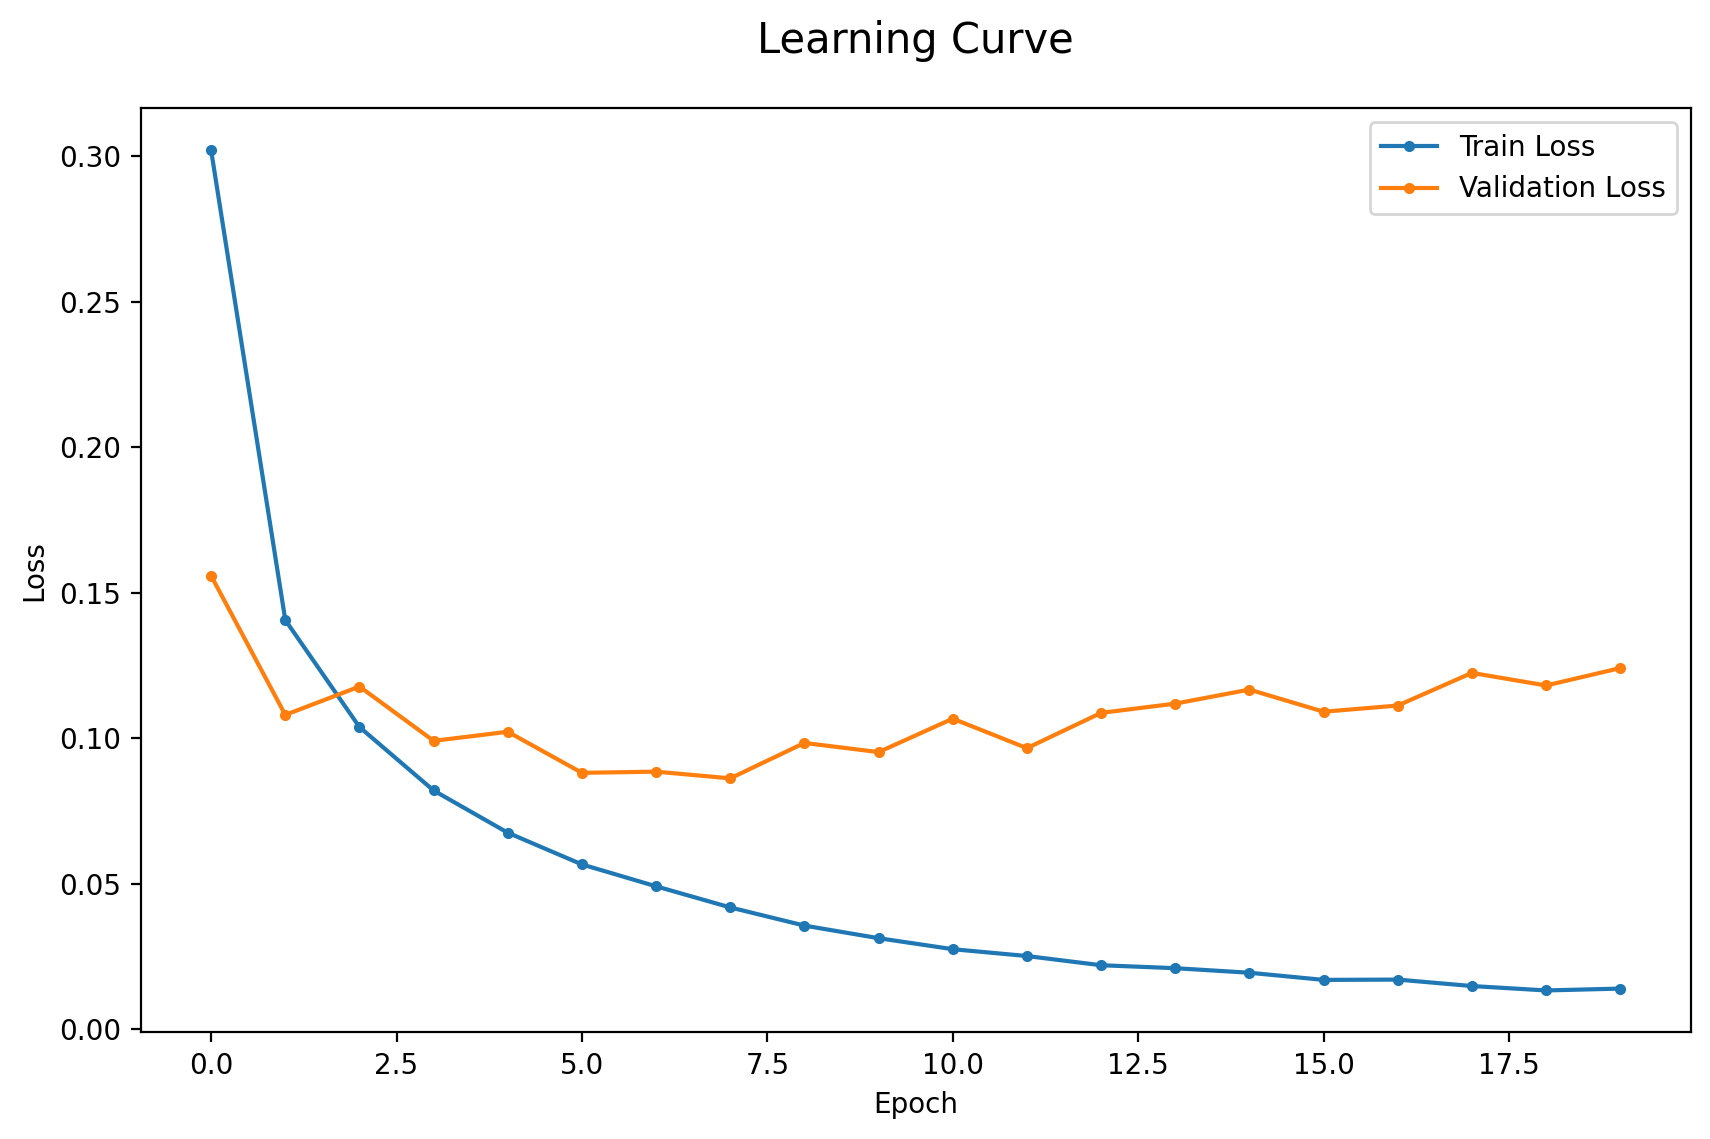

In [23]:
dl_history_plot(hist2)

In [24]:
y_pred2 = model2.predict(x_val)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2[:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([7, 2, 1, 0, 4])

In [25]:
print(accuracy_score(y_val, y_pred2))
print(classification_report(y_val, y_pred2, zero_division=0))
print(confusion_matrix(y_val, y_pred2))

0.9765
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 966    0    1    1    0    1    3    1    3    4]
 [   0 1124    3    0    0    2    1    1    4    0]
 [   0    4 1007    2    1    0    3    6    9    0]
 [   0    1    5  978    0    6    0    6    4   10]
 [   0    0    7    0 